In [5]:
!pip install qiskit>=1.0 qiskit-aer>=0.14

In [17]:
pip install qiskit-aer

Note: you may need to restart the kernel to use updated packages.


In [7]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import QFT
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram

# Parameters
L = 1.0; T = 0.1; nu = 0.05; n_qubits = 3; N = 2**n_qubits

# Step 1: Cole-Hopf transform (initial condition)
x = np.linspace(0, L, N, endpoint=False)
phi0 = np.exp(-np.where(x <= L/2, x/(2*nu), (L-x)/(2*nu)))

# Step 2: State preparation with proper normalization
norm = np.linalg.norm(phi0)
psi0 = phi0 / norm  # Normalize the state vector

# Quantum circuit setup
qc = QuantumCircuit(n_qubits)
qc.initialize(psi0, range(n_qubits))

# Step 3: Quantum evolution (QFT + phase gates)
qc.append(QFT(n_qubits), range(n_qubits))

# Apply exp(-i * ν * t * k^2) for each k
for k in range(N):
    theta = -nu * T * (k**2)
    # Convert k to binary representation and apply phase to corresponding state
    for qubit in range(n_qubits):
        if (k >> qubit) & 1:
            qc.p(theta, qubit)

qc.append(QFT(n_qubits, inverse=True), range(n_qubits))

# Simulation using Statevector
statevector = Statevector.from_instruction(qc)
probs = statevector.probabilities()

# Step 4: Postprocessing
phi_final = np.sqrt(probs) * norm  # Reconstruct ϕ
u = -2*nu * np.gradient(phi_final, x) / phi_final  # Compute u(x,T)

print("Final velocity field u(x,T):", u)

Final velocity field u(x,T): [ 0.43483733  0.6348292   0.40213607 -0.03206207 -0.07706119  0.00296724
  0.07396298  0.4670324 ]


C:\Users\Suptotthita\AppData\Local\Temp\ipykernel_16156\2969718529.py:23: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_qubits), range(n_qubits))
C:\Users\Suptotthita\AppData\Local\Temp\ipykernel_16156\2969718529.py:33: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(n_qubits, inverse=True), range(n_qubits))


In [3]:
pip install qiskit qiskit-aer qiskit-ibm-runtime numpy matplotlib scipy

Note: you may need to restart the kernel to use updated packages.


Classical Preprocessing (Cole-Hopf Transform)

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
L = 1.0          # Domain length
T = 0.1          # Simulation time
nu = 0.05        # Viscosity
u_L, u_R = 1.0, 0.0  # Initial left/right velocities

# Spatial grid (4 points = 2 qubits)
n_qubits = 2
N = 2**n_qubits  # Number of grid points
dx = L/N
x = np.linspace(dx/2, L-dx/2, N)  # Cell-centered grid

# Initial velocity field
u0 = np.where(x <= L/2, u_L, u_R)

# Cole-Hopf transform: Compute initial φ
integral = np.zeros(N)
for i in range(1, N):
    integral[i] = integral[i-1] + (u0[i-1] + u0[i])/2 * dx

phi0 = np.exp(-1/(2*nu) * integral)
norm = np.linalg.norm(phi0)
psi0 = np.sqrt(phi0 / norm)  # Quantum state amplitudes

print("Initial state amplitudes:", psi0)

Initial state amplitudes: [0.99804853 0.28594569 0.1530557  0.1530557 ]


Quantum Circuit Implementation

C:\Users\Suptotthita\AppData\Local\Temp\ipykernel_17052\1201056935.py:28: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft = QFT(n, do_swaps=False)  # Using the standard QFT for now
C:\Users\Suptotthita\AppData\Local\Temp\ipykernel_17052\1201056935.py:41: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft_inv = QFT(n, inverse=True, do_swaps=False)


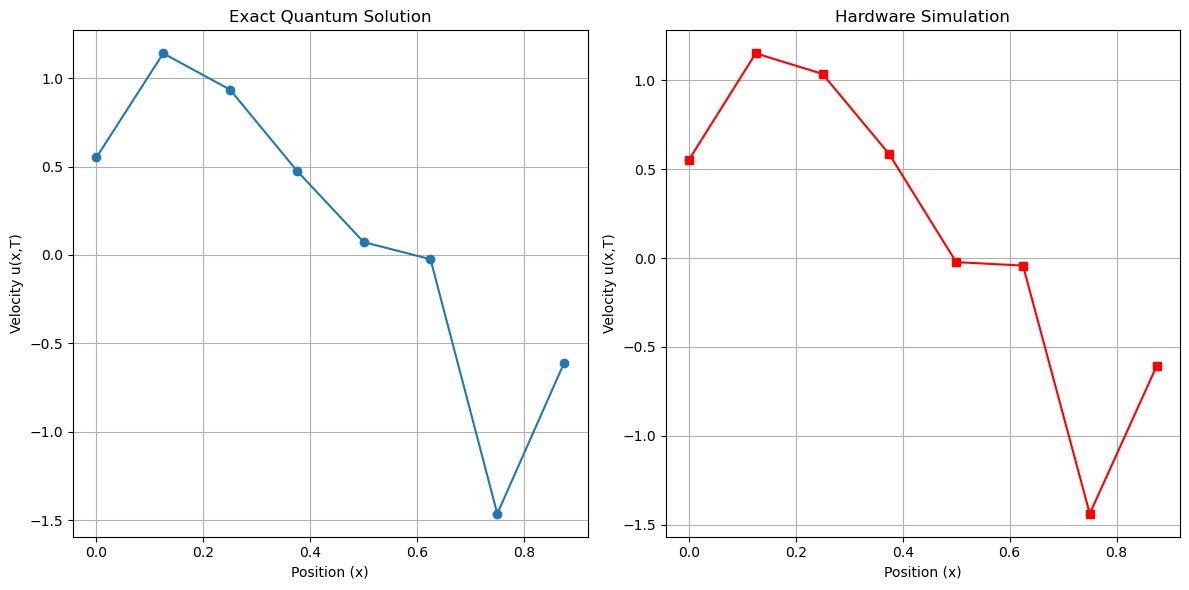

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QFT
from qiskit.quantum_info import Statevector

# Parameters
L = 1.0
T = 0.1
nu = 0.05
n_qubits = 3
N = 2**n_qubits

# Initial condition (Cole-Hopf transformed)
x = np.linspace(0, L, N, endpoint=False)
phi0 = np.exp(-np.where(x <= L/2, x/(2*nu), (L-x)/(2*nu)))
psi0 = phi0 / np.linalg.norm(phi0)  # Normalized state

def create_burgers_circuit(psi0, nu, T, include_measurement=False):
    n = int(np.log2(len(psi0)))
    qc = QuantumCircuit(n)
    
    # State preparation
    qc.initialize(psi0, range(n))
    
    # QFT
    qft = QFT(n, do_swaps=False)  # Using the standard QFT for now
    qc.append(qft, range(n))
    
    # Phase evolution
    for k in range(2**n):
        k_bin = format(k, f'0{n}b')
        k_val = k - 2**(n-1)  # Signed wavenumber
        theta = -nu * T * (k_val**2)
        for qubit in range(n):
            if k_bin[qubit] == '1':
                qc.p(theta, qubit)
    
    # Inverse QFT
    qft_inv = QFT(n, inverse=True, do_swaps=False)
    qc.append(qft_inv, range(n))
    
    if include_measurement:
        qc.measure_all()
    
    return qc

# Create two separate circuits:
# 1. For statevector simulation (no measurements)
qc_statevector = create_burgers_circuit(psi0, nu, T, include_measurement=False)

# 2. For measurement simulation (with measurements)
qc_measure = create_burgers_circuit(psi0, nu, T, include_measurement=True)

# 1. Statevector simulation (exact)
statevector = Statevector.from_instruction(qc_statevector)
probs = statevector.probabilities()
phi_final = np.sqrt(probs) * np.linalg.norm(phi0)
u_quantum = -2*nu * np.gradient(phi_final, x) / phi_final

# 2. Measurement simulation (for hardware-like results)
simulator = AerSimulator()
qc_compiled = transpile(qc_measure, simulator)
job = simulator.run(qc_compiled, shots=10000)
result = job.result()
counts = result.get_counts()
probs_measured = np.array([counts.get(f'{i:0{n_qubits}b}', 0)/10000 for i in range(N)])
phi_measured = np.sqrt(probs_measured) * np.linalg.norm(phi0)
u_measured = -2*nu * np.gradient(phi_measured, x) / phi_measured

# Plotting
plt.figure(figsize=(12, 6))

# Exact solution plot
plt.subplot(1, 2, 1)
plt.plot(x, u_quantum, 'o-', label='Quantum (Statevector)')
plt.title("Exact Quantum Solution")
plt.xlabel("Position (x)")
plt.ylabel("Velocity u(x,T)")
plt.grid()

# Measured results plot
plt.subplot(1, 2, 2)
plt.plot(x, u_measured, 's-', color='red', label='Measured (10k shots)')
plt.title("Hardware Simulation")
plt.xlabel("Position (x)")
plt.ylabel("Velocity u(x,T)")
plt.grid()

plt.tight_layout()
plt.show()

# Circuit visualization (show measurement circuit)
qc_measure.decompose().draw('mpl', fold=50, scale=0.7)
plt.show()